### Dependencies

In [31]:
import sys
import subprocess

def install_and_import(package):
    import importlib
    try:
        importlib.import_module(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

required_packages = [
    "pandas",
    "numpy",
    "shapely",
    "matplotlib",
    "beautifulsoup4",
    "undetected-chromedriver",
    "selenium",
    "rarfile",
    "demoparser2"  # make sure this is a real pip package or provide install instructions
]

for pkg in required_packages:
    install_and_import(pkg)

print("All dependencies checked.")

pandas is already installed.
numpy is already installed.
shapely is already installed.
matplotlib is already installed.
beautifulsoup4 not found. Installing...
undetected-chromedriver not found. Installing...
selenium is already installed.
rarfile is already installed.
demoparser2 is already installed.
All dependencies checked.


In [32]:
import os
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")
import re
import pandas as pd
import time
import zipfile
import rarfile
import subprocess
import gzip
import bz2
import shutil
import pathlib
from pathlib import Path
from typing import Optional
from io import BytesIO
from urllib.parse import urljoin

from demoparser2 import DemoParser

from bs4 import BeautifulSoup
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import random

import concurrent.futures

# Functions

## Webscraping

In [2]:
def setup_undetected_chrome(download_dir: pathlib.Path, headless: bool = False) -> uc.Chrome:
    options = uc.ChromeOptions()
    prefs = {
        "download.default_directory": str(download_dir.resolve()),
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True,
    }
    options.add_experimental_option("prefs", prefs)
    options.headless = headless
    return uc.Chrome(options=options)

def get_soup(driver, url: str, delay: int = 5) -> BeautifulSoup:
    driver.get(url)
    try:
        WebDriverWait(driver, delay).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "a[href^='/matches/']"))
        )
    except Exception:
        time.sleep(delay)
    html = driver.page_source
    return BeautifulSoup(html, "lxml")

def find_match_urls_from_results(driver, max_matches: int = 5, delay: int = 5) -> list[str]:
    soup = get_soup(driver, RESULTS_URL, delay = delay)
    time.sleep(15)
    anchors = soup.select("a[href^='/matches/']")
    urls, seen = [], set()
    for a in anchors: 
        href = a.get("href", "")
        if "/matches/" in href:
            full = urljoin(HLTV_BASE, href)
            if full not in seen: 
                seen.add(full)
                urls.append(full)
    print(f"Found {len(urls)} match links on results page.")
    return urls[:max_matches]
    

def find_demo_download_url(driver, max_wait=6) -> str:
    # match_url: str
    # driver.get(match_url)
    print("Waiting for demo link to become available…")
    for i in range(max_wait):
        try:
            # Try primary robust selector
            link = driver.find_element(By.CSS_SELECTOR, "a.stream-box[data-demo-link-button][data-demo-link]")
            demo_path = link.get_attribute("data-demo-link")
            if demo_path:
                demo_url = urljoin(HLTV_BASE, demo_path)
                print(f"Demo found via CSS selector: {demo_url}")
                return demo_url
        except Exception:
            pass

        # Fallback: try finding any anchor with /download/demo/ in href
        anchors = driver.find_elements(By.TAG_NAME, "a")
        for a in anchors:
            href = a.get_attribute("href")
            if href and "/download/demo/" in href:
                print(f"Demo found via fallback href: {href}")
                return href

        time.sleep(10)
        print(f"… still waiting ({(i+1)*10}s)")

    raise RuntimeError(f"No demo link found on match page after {max_wait*10}s: {match_url}")

def extract_match_data(driver, match_url: str, delay: int = 5) -> dict:
    """
    Extract detailed match data from a single HLTV match page.
    
    Returns a dictionary containing:
    - match_url: The URL of the match
    - team1_name: Name of team 1
    - team2_name: Name of team 2
    - team1_score: Number of maps won by team 1
    - team2_score: Number of maps won by team 2
    - map_1 through map_5: Individual map names (None if not played)
    - total_maps: Total number of maps played
    - date: Match date
    - event: Event name
    - demo_url: Demo download URL (if available)
    """
    soup = get_soup(driver, match_url, delay=delay)
    
    match_data = {
        'match_url': match_url,
        'team1_name': None,
        'team2_name': None,
        'team1_score': 0,
        'team2_score': 0,
        'map_1': None,
        'map_2': None,
        'map_3': None,
        'map_4': None,
        'map_5': None,
        'total_maps': 0,
        'date': None,
        'event': None,
        'demo_url': None
    }
    
    # Extract team names and scores
    teams = soup.find_all('div', class_='team')
    if len(teams) >= 2:
        # Team 1 (left side)
        team1 = teams[0]
        team1_name_elem = team1.find('div', class_='teamName')
        if team1_name_elem:
            match_data['team1_name'] = team1_name_elem.text.strip()
        
        # Check if team1 won or lost and get score
        team1_won = team1.find('div', class_='won')
        team1_lost = team1.find('div', class_='lost')
        if team1_won:
            score_text = team1_won.text.strip()
            try:
                match_data['team1_score'] = int(score_text)
            except ValueError:
                pass
        elif team1_lost:
            score_text = team1_lost.text.strip()
            try:
                match_data['team1_score'] = int(score_text)
            except ValueError:
                pass
        
        # Team 2 (right side)
        team2 = teams[1]
        team2_name_elem = team2.find('div', class_='teamName')
        if team2_name_elem:
            match_data['team2_name'] = team2_name_elem.text.strip()
        
        # Check if team2 won or lost and get score
        team2_won = team2.find('div', class_='won')
        team2_lost = team2.find('div', class_='lost')
        if team2_won:
            score_text = team2_won.text.strip()
            try:
                match_data['team2_score'] = int(score_text)
            except ValueError:
                pass
        elif team2_lost:
            score_text = team2_lost.text.strip()
            try:
                match_data['team2_score'] = int(score_text)
            except ValueError:
                pass
    
    # Extract maps that were played
    maps_played = []
    mapholders = soup.find_all('div', class_='mapholder')
    for mapholder in mapholders:
        # Check if this map was actually played
        played = mapholder.find('div', class_='played')
        if played:
            mapname_elem = mapholder.find('div', class_='mapname')
            if mapname_elem:
                map_name = mapname_elem.text.strip()
                maps_played.append(map_name)
    
    # Assign maps to individual columns (up to 5 maps)
    for i, map_name in enumerate(maps_played[:5], 1):
        match_data[f'map_{i}'] = map_name
    
    match_data['total_maps'] = len(maps_played)
    
    # Extract date and event
    time_and_event = soup.find('div', class_='timeAndEvent')
    if time_and_event:
        # Extract date
        date_elem = time_and_event.find('div', class_='date')
        if date_elem:
            match_data['date'] = date_elem.text.strip()
        
        # Extract event name
        event_elem = time_and_event.find('div', class_='event text-ellipsis')
        if event_elem:
            match_data['event'] = event_elem.text.strip()
    
    # Extract demo download URL
    try:
        demo_url = find_demo_download_url(driver, max_wait=6)
        match_data['demo_url'] = demo_url
    except Exception as e:
        print(f"Error getting demo URL: {e}")
        match_data['demo_url'] = None
    
    return match_data

def scrape_multiple_matches(driver, match_urls, delay: int = 5) -> list[dict]:
    """
    Scrape data from multiple matches on the results page.
    
    Returns a list of dictionaries, each containing match data.
    """
    all_match_data = []
    
    for i, match_url in enumerate(match_urls, 1):
        print(f"\nScraping match {i}/{len(match_urls)}: {match_url}")
        try:
            match_data = extract_match_data(driver, match_url, delay=delay)
            all_match_data.append(match_data)
            maps_str = ', '.join([match_data[f'map_{j}'] for j in range(1, 6) if match_data[f'map_{j}'] is not None])
            # print(f"  - {match_data['team1_name']} vs {match_data['team2_name']}: {match_data['team1_score']}-{match_data['team2_score']}")
            # print(f"  - Maps played: {maps_str}")
            # print(f"  - Demo URL: {match_data['demo_url']}")
        except Exception as e:
            print(f"Error scraping {match_url}: {e}")
        
        # Add delay between requests to avoid rate limiting
        if i < len(match_urls):
            time.sleep(REQUEST_DELAY_SEC)
    
    return all_match_data

def save_match_data_to_csv(match_data_list: list[dict], output_file: str = "hltv_matches.csv"):
    """
    Save scraped match data to a CSV file.
    """
    df = pd.DataFrame(match_data_list)
    
    # Reorder columns for better readability
    column_order = [
        'match_url', 'demo_url', 'date', 'event',
        'team1_name', 'team2_name', 
        'team1_score', 'team2_score',
        'total_maps',
        'map_1', 'map_2', 'map_3', 'map_4', 'map_5'
    ]
    
    df = df[column_order]
    df.to_csv(output_file, index=False)
    print(f"\nData saved to {output_file}")
    return df

## Downloading

In [3]:
def human_size(bytes_):
    for unit in ['B', 'KB', 'MB', 'GB']:
        if bytes_ < 1024:
            return f"{bytes_:3.1f} {unit}"
        bytes_ /= 1024
    return f"{bytes_:3.1f} TB"

def get_demo_number_from_url(demo_url: str) -> str:
    # Extract the number at the end of the demo URL, e.g., '102077' from 'https://www.hltv.org/download/demo/102077'
    match = re.search(r'/demo/(\d+)', demo_url)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Could not find demo number in URL: {demo_url}")

def download_demo_with_selenium(driver, demo_url: str, out_dir: pathlib.Path) -> pathlib.Path:
    driver.get(demo_url)
    size_prev = 0
    start = time.time()
    final_file = None
    print("▶ Starting download…")
    
    while True:
        candidates = []
        for ext in ['zip', 'rar', 'gz', 'bz2', 'dem']:
            candidates += list(out_dir.glob(f"*.{ext}"))
        if candidates:
            final_file = max(candidates, key=lambda f: f.stat().st_ctime)
            # NEW: Wait for file size to stabilize
            time.sleep(3)
            stable_size = final_file.stat().st_size
            time.sleep(2)
            if final_file.stat().st_size == stable_size and stable_size > 0:
                print(f"\n✅ Download complete: {final_file.name} ({human_size(stable_size)})")
                break
            else:
                print(f"\r📦 Finalizing... {human_size(stable_size)}", end="")
                final_file = None
                continue

        partials = list(out_dir.glob("*.crdownload"))
        if partials:
            part = partials[0]
            size = part.stat().st_size
            if size != size_prev:
                print(f"\r📦 Downloading... {human_size(size)}", end="")
                size_prev = size

        if time.time() - start > 3600:
            print("\n⚠ Timed out waiting for download to finish.")
            break
        time.sleep(1)
    
    if not final_file:
        raise RuntimeError("No finished demo file detected after timeout.")
    
    # Additional wait to ensure Chrome finishes all file operations
    print("Waiting for file system sync...")
    time.sleep(5)
    return final_file

def extract_dem_from_file(archive_path: pathlib.Path, out_dir: pathlib.Path, name_filter: str = None) -> pathlib.Path:
    out_dir.mkdir(parents=True, exist_ok=True)
    suffix = archive_path.suffix.lower()

    def matches_filter(filename):
        return name_filter.lower() in filename.lower() if name_filter else True

    # Diagnostic: print header bytes
    with open(archive_path, 'rb') as f:
        header = f.read(16)
        print(f"   Header (hex): {header[:8].hex()}")

    if suffix == ".dem":
        if not matches_filter(archive_path.name):
            raise RuntimeError(f".dem file '{archive_path.name}' does not match filter '{name_filter}'. Skipping.")
        target = out_dir / archive_path.name
        shutil.copy2(archive_path, target)
        return target

    if suffix == ".zip":
        with zipfile.ZipFile(archive_path, "r") as z:
            dem_members = [m for m in z.namelist() if m.lower().endswith(".dem") and matches_filter(m)]
            if not dem_members:
                raise RuntimeError(f"No .dem matching filter '{name_filter}' found inside zip: {archive_path.name}")
            # Extract all filtered dem files and return first one
            for dem_file in dem_members:
                z.extract(dem_file, out_dir)
            return out_dir / dem_members[0]

    if suffix == ".rar":
        # Find WinRAR/UnRAR executable path
        winrar_paths = [
            r"C:\Program Files\WinRAR\WinRAR.exe",
            r"C:\Program Files (x86)\WinRAR\WinRAR.exe",
            r"C:\Program Files\WinRAR\UnRAR.exe",
            r"C:\Program Files (x86)\WinRAR\UnRAR.exe",
        ]
        unrar_path = None
        for path in winrar_paths:
            if os.path.exists(path):
                unrar_path = path
                break
    
        if not unrar_path:
            raise RuntimeError("WinRAR/UnRAR not found! Please install WinRAR or add UnRAR to PATH.")
    
        print(f"[rar] Using: {unrar_path}")
    
        # List archive contents using rarfile
        with rarfile.RarFile(str(archive_path), 'r') as rf:
            file_names = rf.namelist()
            matching_files = [f for f in file_names if f.lower().endswith('.dem') and (name_filter is None or name_filter.lower() in f.lower())]
    
        if not matching_files:
            if name_filter:
                raise RuntimeError(f"No .dem files matching filter '{name_filter}' found inside archive.")
            else:
                matching_files = [f for f in file_names if f.lower().endswith('.dem')]
                if not matching_files:
                    raise RuntimeError("No .dem files found inside archive.")
    
        # Extract only matching files using subprocess with WinRAR/UnRAR
        for file_to_extract in matching_files:
            print(f"[rar] Extracting file: {file_to_extract}")
            extract_result = subprocess.run(
                [unrar_path, "x", "-y", str(archive_path), file_to_extract, str(out_dir)],
                capture_output=True,
                text=True,
                timeout=600
            )
            print(f"[rar] Extract stdout: {extract_result.stdout[:200]}")
            print(f"[rar] Extract stderr: {extract_result.stderr[:200]}")
    
        # After extraction, return first matched .dem file path in out_dir
        dem_files = [f for f in out_dir.glob("*") if f.name in matching_files]
        if dem_files:
            return dem_files[0]
        else:
            raise RuntimeError("Extraction completed but .dem file not found in output.")

## Parsing

In [4]:
def parse_demo(dem_path: pathlib.Path, base_csv_dir: pathlib.Path, match_name: str, demo_id: str):
    dem_name = dem_path.stem

    print(f"Parsing demo: {dem_name}")
    parser = DemoParser(str(dem_path))

    KNOWN_MAPS = ["nuke", "mirage", "dust2", "inferno", "overpass", "train", "vertigo"]

    def extract_map_name(dem_name):
        dem_name_lower = dem_name.lower()
        for map_name in KNOWN_MAPS:
            if map_name in dem_name_lower:
                return map_name
        match = re.search(r"\b(" + "|".join(KNOWN_MAPS) + r")\b", dem_name_lower)
        if match:
            return match.group(1)
        return None

    meta = {
        "match": match_name,
        "demo_name": dem_name,
        "demo_path": str(dem_path),
        "date": None,
        "map": extract_map_name(dem_name),
        "total_rounds": None,
        "rounds_started": 0,
        "rounds_ended": 0,}

    try:
        meta["date"] = parser.match.date.strftime("%Y-%m-%d") if hasattr(parser, "match") and parser.match and parser.match.date else None
    except Exception:
        pass

    event_types = {
        "player_death": ["X", "Y", "attacker", "victim", "weapon", "total_rounds_played"],
        # Add other event types if needed
    }

    base_csv_dir.mkdir(parents=True, exist_ok=True)

    for event, fields in event_types.items():
        folder = base_csv_dir / event
        folder.mkdir(parents=True, exist_ok=True)

        try:
            result = parser.parse_event(event, player=fields)
            df = pd.DataFrame(result) if isinstance(result, list) else result
            df['demo_id'] = demo_id
            csv_path = folder / f"{dem_name}_{event}.csv"
            df.to_csv(csv_path, index=False)
            print(f"✅ Exported {event} events to {csv_path} (rows={len(df)})")

            if event == "round_start":
                meta["rounds_started"] = len(df)
                meta["total_rounds"] = len(df)
            elif event == "round_end":
                meta["rounds_ended"] = len(df)

        except Exception as e:
            print(f"⚠ Failed to export {event} events: {e}")

    all_props = [
        "X", "Y", "Z", "health", "armor_value", "has_helmet",
        "is_alive", "life_state", "active_weapon", "active_weapon_name",
        "inventory", "total_cash_spent","cash_spent_this_round",
        "team_num", "is_bomb_dropped", "is_bomb_planted",
        "total_rounds_played", "round_start_time", "game_time", "team_rounds_total" ]

    try:
        tick_folder = base_csv_dir / "ticks"
        tick_folder.mkdir(parents=True, exist_ok=True)
        ticks_df = parser.parse_ticks([
            "X","Y","Z","health","is_alive",
            "active_weapon", "active_weapon_name",
            "inventory", "total_cash_spent","cash_spent_this_round", "team_num",
            "total_rounds_played", "round_start_time", "game_time", "team_rounds_total"],)
        ticks_df['demo_id'] = demo_id
        tick_csv_path = tick_folder / f"{dem_name}_ticks.csv"
        ticks_df.to_csv(tick_csv_path, index=False)
        print(f"✅ Exported ticks to {tick_csv_path} (rows={len(ticks_df)})")
    except Exception as e:
        print(f"⚠ Failed to export ticks: {e}")

def parse_demo_with_timeout(dem_path: pathlib.Path, base_csv_dir: pathlib.Path, master_csv_path: pathlib.Path, match_name: str, timeout_sec=300):
    """
    Parses a demo with a timeout. If parsing exceeds `timeout_sec` seconds, skip and warn.
    """
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
        future = executor.submit(parse_demo, dem_path, base_csv_dir, master_csv_path, match_name)
        try:
            future.result(timeout=timeout_sec)
        except concurrent.futures.TimeoutError:
            print(f"⚠ Parsing of {dem_path} took longer than {timeout_sec} seconds and was skipped.")
            # Forcefully terminate the process
            executor.shutdown(wait=False, cancel_futures=True)

def parse_demos(structured_root):
    base_dir = pathlib.Path("hltv_demos")
    matches_csv_path = "hltv_matches.csv"

    df = pd.read_csv(matches_csv_path)

    for idx, info in df.iterrows():
        dem_path_str = info.get('dem_path', "")
        
        # Check dem_path_str is a valid, non-empty string
        if not isinstance(dem_path_str, str) or dem_path_str.strip() == "":
            print(f"Skipping demo at row {idx} because dem_path is empty or invalid")
            continue
            
        status = str(info.get('parsed_status', "")).lower()
        if not dem_path_str or status in {"parsed", "skip"}:
            print(f"Skipping demo at row {idx} due to status: '{status}'")
            continue

        dem_path = pathlib.Path(dem_path_str)
        match_name = info.get('match_name', "")
        demo_url = info.get('demo_url','')
        demo_id = demo_url.rstrip('/').split('/')[-1]
        try:
            # Call parse_demo without master_csv_path argument
            parse_demo(dem_path, structured_root, match_name, demo_id)
            
            df.at[idx, 'parsed_status'] = "parsed"
            df.to_csv(matches_csv_path, index=False)
            print(f"✅ Parsed demo {dem_path}")
        except Exception as e:
            print(f"⚠ Failed to parse demo {dem_path}: {e}")

## Transformation

In [5]:
def add_next_tick_position(df, ticks_ahead=32, tick_interval=16):
    """
    Add next position columns for each player.
    
    Args:
        df: DataFrame with steamid, tick, X, Y columns
        ticks_ahead: Number of game ticks to look ahead (default 32)
        tick_interval: Interval between rows in ticks (default 16)
        
    Returns:
        DataFrame with X_next, Y_next, tick_next columns
    """
    # Sort to ensure correctness (by player and tick)
    df = df.sort_values(['steamid', 'tick'])
    
    # Calculate how many rows to shift based on tick interval
    rows_to_shift = ticks_ahead // tick_interval
    
    # Compute next tick positions for each player's ordered ticks
    df['X_next'] = df.groupby('steamid')['X'].shift(-rows_to_shift)
    df['Y_next'] = df.groupby('steamid')['Y'].shift(-rows_to_shift)
    df['tick_next'] = df.groupby('steamid')['tick'].shift(-rows_to_shift)
    
    return df
    
def add_teammates_alive(df):
    """
    Add teammates_alive column to dataframe.
    
    Args:
        df: DataFrame with 'tick', 'team_num', and 'is_alive' columns
        
    Returns:
        DataFrame with added 'teammates_alive' column
    """
    df['is_alive_bool'] = df['is_alive'].astype(bool)
    
    alive_counts_tm = (
        df[df['is_alive_bool']]
        .groupby(['tick', 'team_num'])
        .size()
        .reset_index(name='alive_count_tm')
    )
    
    df = df.merge(alive_counts_tm, how='left', on=['tick', 'team_num'])
    df['teammates_alive'] = df['alive_count_tm'].fillna(0).astype(int) - df['is_alive'].astype(int)
    df = df.drop(columns=['alive_count_tm'], errors='ignore')
    
    return df


def add_enemies_alive(df):
    """
    Add enemies_alive column to dataframe.
    
    Args:
        df: DataFrame with 'tick', 'team_num', and 'is_alive_bool' columns
        
    Returns:
        DataFrame with added 'enemies_alive' column
    """
    alive_counts_all = (
        df[df['is_alive_bool']]
        .groupby(['tick', 'team_num'])
        .size()
        .reset_index(name='alive_count_any_team')
    )
    
    total_alive_per_tick = (
        alive_counts_all
        .groupby('tick')['alive_count_any_team']
        .sum()
        .reset_index(name='total_alive')
    )
    
    alive_counts_all = alive_counts_all.merge(total_alive_per_tick, on='tick')
    alive_counts_all['enemies_alive'] = (
        alive_counts_all['total_alive'] - alive_counts_all['alive_count_any_team']
    )
    
    df = df.merge(
        alive_counts_all[['tick', 'team_num', 'enemies_alive']],
        how='left',
        on=['tick', 'team_num']
    )
    
    return df


def add_teammate_zones(df, label_col='current_zone', max_teammates=4):
    """
    Add teammate zone columns to dataframe.
    
    Args:
        df: DataFrame with 'tick', 'team_num', 'is_alive_bool', and label_col columns
        label_col: Name of the column containing zone labels
        max_teammates: Maximum number of teammates to track (default 4 for CS:GO)
        
    Returns:
        DataFrame with added 'teammate_1_zone', 'teammate_2_zone', etc. columns
    """
    # Aggregate all zones for each team at each tick
    teammate_zones = (
        df[df['is_alive_bool']]
        .groupby(['tick', 'team_num'])[label_col]
        .agg(lambda x: list(x))
        .reset_index()
        .rename(columns={label_col: 'teammate_zones_all'})
    )
    
    df = df.merge(teammate_zones, how='left', on=['tick', 'team_num'])
    
    # Extract teammate zones (excluding own zone) into separate columns
    def extract_teammate_zones(row):
        zones_all = row['teammate_zones_all']
        
        # Check if value is NaN or not a list
        if not isinstance(zones_all, list):
            zones = []
        else:
            zones = zones_all.copy()
            try:
                zones.remove(row[label_col])  # Remove player's own zone
            except ValueError:
                pass  # Own zone not in list (e.g., player is dead)
        
        # Pad or truncate to max_teammates
        zones = zones[:max_teammates]  # Truncate if more
        zones += [''] * (max_teammates - len(zones))  # Pad if fewer
        
        return pd.Series({f'teammate_{i+1}_zone': zone for i, zone in enumerate(zones)})
    
    # Apply and concatenate teammate zone columns
    teammate_cols = df.apply(extract_teammate_zones, axis=1)
    df = pd.concat([df, teammate_cols], axis=1)
    
    # Clean up temporary column
    df = df.drop(columns=['teammate_zones_all'], errors='ignore')
    
    return df


### Coordinate Labeling

In [6]:
def load_map_data(csv_file='map_bounds-in.csv'):
    df = pd.read_csv(csv_file)
    
    # Group coordinates by map and area name
    maps = {}
    for (map_name, area_name), group in df.groupby(['map', 'name']):
        coords = list(zip(group['x_axis'], group['y_axis']))
        if len(coords) >= 3:
            if map_name not in maps:
                maps[map_name] = {}
            maps[map_name][area_name] = Polygon(coords)
    
    return maps

def label_coordinate(x, y, map_name, maps):
    """
    Given X, Y coordinates and a map name, return the label of the area
    within that map. If not inside any area, return the closest area's name.

    Parameters:
    x, y (float): Coordinates to label
    map_name (str): Map to consider during labeling
    maps (dict): Dictionary of maps with area polygons

    Returns:
    str: Area name label
    """
    if map_name not in maps:
        return "Unknown Map"
    
    point = Point(x, y)
    min_dist = float('inf')
    closest_area = "Unknown"
    for area_name, polygon in maps[map_name].items():
        if polygon.contains(point):
            return area_name
        d = point.distance(polygon.centroid)
        if d < min_dist:
            min_dist = d
            closest_area = area_name
    return closest_area

def label_coordinates_batch(coordinates, map_name, maps):
    """
    Label multiple coordinates for a given map.

    Parameters:
    coordinates (list): List of (x, y) tuples
    map_name (str): Map to consider during labeling
    maps (dict): Dictionary of maps with area polygons

    Returns:
    list: Area names corresponding to each coordinate
    """
    results = []
    for x, y in coordinates:
        label = label_coordinate(x, y, map_name, maps)
        results.append(label)
    return results

def plot_areas(areas):
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    colors = {}

    for area_name, polygon in areas.items():
        x, y = polygon.exterior.xy
        # Assign a random color to each polygon
        if area_name not in colors:
            colors[area_name] = (random.random(), random.random(), random.random())
        ax.fill(x, y, alpha=0.5, fc=colors[area_name], ec='black', linewidth=1, label=area_name)

        # Label the polygon at its centroid
        centroid = polygon.centroid
        plt.text(centroid.x, centroid.y, area_name, fontsize=10, ha='center', va='center')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Map Areas Visualization')
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Execution

The pipeline is divided into key stages:

1. **Scraping:** Extracts URLs and match metadata from the first page of the filtered HLTV results, saving them into a tracking CSV (`hltv_matches.csv`).

2. **Downloading & Extraction:** Downloads the demo files (.dem) corresponding to the scraped links and extracts them from archives. You can limit how many demos to download and filter by map name.

3. **Parsing:** Uses the custom `demoparser2` library to parse raw demo files into structured game event data and tick information in CSV format.

4. **Transformation & Labeling:** Converts raw parsed data into engineered features representing game states per tick, such as player positions and alive status. Each tick is spatially labeled with map zones to provide contextual game information.


## Scraping Master List of Demos

In [ ]:
HLTV_BASE = "https://www.hltv.org"
Filters = "?startDate=2024-11-19&endDate=2025-11-19&stars=3&map=de_dust2"
RESULTS_URL = f"{HLTV_BASE}/results{Filters}"
REQUEST_DELAY_SEC = 5
print(RESULTS_URL)

if __name__ == "__main__":
    # Setup
    download_dir = pathlib.Path("./downloads")
    download_dir.mkdir(exist_ok=True)
    
    driver = setup_undetected_chrome(download_dir)
    
    try:
        # You may want to pass a less filtered results URL to see if this works!
        match_urls = find_match_urls_from_results(driver, max_matches=100, delay=5)
        if not match_urls:
            print("No matches found with the given parameters and filters.")
        else:
            matches = scrape_multiple_matches(driver, match_urls)
            if not matches:
                print("No match data extracted (possibly due to page change or filter).")
            else:
                df = save_match_data_to_csv(matches, "hltv_matches.csv")
                print("\n=== Summary ===")
                print(df)
    finally:
        driver.quit()

## Download, Extract, Parse

### Download & Extraction

Make sure you have extracted the `hltv_matches.csv` file before using this function. Downloads can be selectively skipped by marking "Skip" in the `"parsed_status"` column of the CSV. 

This stage downloads demo files (.dem) from the URLs listed in the tracking CSV, extracts them from any compressed archives (e.g., zip, rar), and saves them locally for parsing. You can control the maximum number of demos to download and filter demos by map name. This ensures efficient and manageable processing, and avoids re-downloading demos already marked to skip.

In [11]:
def download_and_extract(max_downloads=None, name_filter: str = None):
    base_dir = pathlib.Path("hltv_demos")
    download_root = base_dir / "downloads"
    extract_root = base_dir / "extracted"
    download_root.mkdir(parents=True, exist_ok=True)
    extract_root.mkdir(parents=True, exist_ok=True)

    REQUEST_DELAY_SEC = 5

    df = pd.read_csv("hltv_matches.csv")
    filtered = df[df["demo_url"].notnull()]
    print(f"Found {len(filtered)} demo links in CSV.")

    # Add or initialize columns if missing
    if 'dem_path' not in df.columns:
        df['dem_path'] = ""
    if 'match_name' not in df.columns:
        df['match_name'] = ""
    if 'parsed_status' not in df.columns:
        df['parsed_status'] = ""

    # Skip rows already parsed or marked to skip
    filtered = filtered[(df['parsed_status'] != "parsed") & (df['parsed_status'] != "Skip")]

    # Limit number of downloads if specified
    if max_downloads is not None:
        filtered = filtered.iloc[:max_downloads]

    for idx, row in filtered.iterrows():
        match_url = row["match_url"]
        demo_url = row["demo_url"]
        print(f"\n === [{idx+1}/{len(filtered)}] {match_url} ===")
        print(f"Demo URL: {demo_url}")
        time.sleep(10)

        try:
            demo_number = get_demo_number_from_url(demo_url)
            demo_download_dir = download_root / demo_number
            demo_download_dir.mkdir(parents=True, exist_ok=True)

            driver = setup_undetected_chrome(download_dir=demo_download_dir, headless=False)
            archive_path = download_demo_with_selenium(driver, demo_url, demo_download_dir)
            match_name = archive_path.stem

            while any(demo_download_dir.glob("*.crdownload")):
                print("Waiting for partial downloads to finish...")
                time.sleep(30)

            before_extraction = set(extract_root.glob("*.dem"))
            dem_path = extract_dem_from_file(archive_path, extract_root, name_filter)
            after_extraction = set(extract_root.glob("*.dem"))
            new_dem_files = after_extraction - before_extraction

            for new_dem in new_dem_files:
                existing_dem_path = df.at[idx, 'dem_path']
                if pd.isna(existing_dem_path) or existing_dem_path == "":
                    df.at[idx, 'dem_path'] = str(new_dem)
                else:
                    print(f"⚠ dem_path already exists for row {idx}, skipping update.")

                existing_match_name = df.at[idx, 'match_name']
                if pd.isna(existing_match_name) or existing_match_name == "":
                    df.at[idx, 'match_name'] = match_name
                else:
                    print(f"⚠ match_name already exists for row {idx}, skipping update.")
            
            # Mark this row as 'downloaded' and ready for parsing or set your own logic here
            df.at[idx, 'Status'] = "downloaded"

            driver.quit()
        except Exception as e:
            print(f"⚠ Skipping this demo due to error: {e}")
            df.at[idx, 'parsed_status'] = "Skip"

        time.sleep(REQUEST_DELAY_SEC)

    # Overwrite the original CSV
    df.to_csv("hltv_matches.csv", index=False)
    print("Updated hltv_matches.csv with enriched demo info and parsing status.")

In [15]:
base_dir = pathlib.Path("hltv_demos")
structured_root = base_dir / "structured"
structured_root.mkdir(parents=True, exist_ok=True)

demo_infos = download_and_extract(max_downloads=40, name_filter = "dust2")


Found 78 demo links in CSV.

 === [46/33] https://www.hltv.org/matches/2381324/falcons-vs-the-mongolz-pgl-bucharest-2025 ===
Demo URL: https://www.hltv.org/download/demo/96280


C:\Users\Owner\AppData\Local\Temp\ipykernel_21532\2666659749.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered = filtered[(df['parsed_status'] != "parsed") & (df['parsed_status'] != "skip")]


▶ Starting download…
📦 Downloading... 999.2 MB
✅ Download complete: pgl-bucharest-2025-falcons-vs-the-mongolz-bo3-bbFLmKEuAS639D3PSEih-7.rar (999.2 MB)
Waiting for file system sync...
   Header (hex): 526172211a070100
[rar] Using: C:\Program Files\WinRAR\WinRAR.exe
[rar] Extracting file: falcons-vs-the-mongolz-m2-dust2.dem
[rar] Extract stdout: 
[rar] Extract stderr: 

 === [47/33] https://www.hltv.org/matches/2380134/mouz-vs-vitality-blast-open-lisbon-2025 ===
Demo URL: https://www.hltv.org/download/demo/95912
▶ Starting download…
📦 Downloading... 1.4 GB MB
✅ Download complete: blast-open-lisbon-2025-mouz-vs-vitality-bo5-g3-5jFl1QSVPqll-eeCKIE.rar (1.4 GB)
Waiting for file system sync...
   Header (hex): 526172211a070100
[rar] Using: C:\Program Files\WinRAR\WinRAR.exe
[rar] Extracting file: mouz-vs-vitality-m3-dust2.dem
[rar] Extract stdout: 
[rar] Extract stderr: 

 === [48/33] https://www.hltv.org/matches/2380133/eternal-fire-vs-mouz-blast-open-lisbon-2025 ===
Demo URL: https://www.

### Parsing
This function parses all demo files located in the "extracted" folder. To skip parsing any demos, mark "Skip" in the `"parsed_status"` column of the `hltv_matches.csv` file. The parsing uses the custom `demoparser2` library to convert raw demo data into structured CSV files with detailed game event and tick-level information, which are then used for further processing and analysis.

In [16]:
base_dir = pathlib.Path("hltv_demos")
structured_root = base_dir / "structured"
structured_root.mkdir(parents=True, exist_ok=True)

# Load enriched hltv_matches.csv containing all demo metadata and parsing status
matches_csv_path = "hltv_matches.csv"
df_matches = pd.read_csv(matches_csv_path)

# Convert 'dem_path' strings to pathlib.Path objects for parsing function
df_matches['dem_path'] = df_matches['dem_path'].apply(lambda p: pathlib.Path(p) if pd.notna(p) and p != "" else None)

# Call parse_demos with the DataFrame instead of a separate demo_infos list
parse_demos(structured_root)

Skipping demo at row 0 because dem_path is empty or invalid
Skipping demo at row 1 due to status: 'parsed'
Skipping demo at row 2 due to status: 'parsed'
Skipping demo at row 3 due to status: 'parsed'
Skipping demo at row 4 due to status: 'parsed'
Skipping demo at row 5 due to status: 'parsed'
Skipping demo at row 6 due to status: 'parsed'
Skipping demo at row 7 due to status: 'parsed'
Skipping demo at row 8 due to status: 'parsed'
Skipping demo at row 9 due to status: 'parsed'
Skipping demo at row 10 due to status: 'parsed'
Skipping demo at row 11 due to status: 'parsed'
Skipping demo at row 12 due to status: 'parsed'
Skipping demo at row 13 due to status: 'parsed'
Skipping demo at row 14 due to status: 'parsed'
Skipping demo at row 15 due to status: 'parsed'
Skipping demo at row 16 due to status: 'parsed'
Skipping demo at row 17 due to status: 'parsed'
Skipping demo at row 18 due to status: 'parsed'
Skipping demo at row 19 due to status: 'parsed'
Skipping demo at row 20 due to status

## Transformation

This stage processes the parsed demo data to create informative features for each game tick. It adds future player positions, counts of teammates and enemies alive, and teammate zone information, transforming raw event data into a structured representation of the game state. 

If you want to skip transformation for any demos, mark "Skip" in the `"labeled_status"` column of the `hltv_matches.csv` file. All successfully transformed and labeled data will be saved in the labeled data directory for easy access and further analysis.

In [17]:
def label_all_ticks_in_dir(
    ticks_dir,
    areas,
    map_name,
    x_col="X",
    y_col="Y",
    label_col="current_zone",  
):
    """
    Label all tick CSV files in a directory with zone and teammate information.
    
    Args:
        ticks_dir: Path to directory containing tick CSV files
        areas: Dict of area_name -> shapely Polygon for zone labeling
        x_col: Name of X coordinate column
        y_col: Name of Y coordinate column
        label_col: Name of the zone label column
    """
    ticks_dir = Path(ticks_dir)
    labeled_dir = ticks_dir.parent / "labeled"
    labeled_dir.mkdir(exist_ok=True)
    
    # Load and prepare matches tracking CSV
    matches_csv_path = "hltv_matches.csv"
    df_matches = pd.read_csv(matches_csv_path)
    
    if 'labeled_status' not in df_matches.columns:
        df_matches['labeled_status'] = pd.Series(dtype='string')
    else:
        df_matches['labeled_status'] = df_matches['labeled_status'].astype('string')
    
    # Process each tick file
    files = list(ticks_dir.glob("*.csv"))
    for file in files:
        dem_name_from_tick = file.stem.replace('_ticks', '')
        
        # Find matching row in hltv_matches.csv
        match_rows = df_matches[
            df_matches['dem_path'].apply(
                lambda p: pathlib.Path(p).stem if pd.notna(p) else ''
            ) == dem_name_from_tick
        ]
        
        # Check if already labeled or should skip
        if not match_rows.empty:
            val = match_rows.iloc[0].get('labeled_status')
            status = '' if pd.isna(val) else str(val).lower()
            
            if status in {"labeled", "skip"}:
                print(f"Skipping labeling for {file.name} due to status: '{status}'")
                continue
                
            row_index = match_rows.index[0]
        else:
            row_index = None
        
        # Process the file
        print(f"Processing {file.name} ...")
        df = pd.read_csv(file, low_memory=False)
        
        # Filter to every 16th tick and remove invalid coordinates
        df = df[df["tick"] % 32 == 0]
        df = df.dropna(subset=[x_col, y_col])
        
        # Label zones using coordinate labeling function
        df[label_col] = df.apply(
            lambda row: label_coordinate(row[x_col], row[y_col], map_name, areas), 
            axis=1
        )
        # Add next tick position
        df = add_next_tick_position(df, ticks_ahead=32, tick_interval=32)

        df['next_zone'] = df.apply(
            lambda row: label_coordinate(row['X_next'], row['Y_next'], map_name, areas), 
            axis=1)

        # Add all features
        df = add_teammates_alive(df)
        df = add_enemies_alive(df)
        df = add_teammate_zones(df, label_col=label_col)
        
        # Clean up temporary columns
        df = df.drop(columns=['is_alive_bool'], errors='ignore')
        
        # Save labeled file
        output_path = labeled_dir / file.name
        df.to_csv(output_path, index=False)
        print(f"Saved labeled CSV to {output_path}")
        
        # Update status in tracking CSV
        if row_index is not None:
            df_matches.at[row_index, 'labeled_status'] = 'labeled'
        else:
            print(f"Warning: No matching row found in hltv_matches.csv for {file.name}")
    
    # Save updated tracking CSV
    df_matches.to_csv(matches_csv_path, index=False)
    print(f"Processing complete. Updated {matches_csv_path}")



In [19]:
areas = load_map_data('map_bounds(in).csv')
labeled = label_all_ticks_in_dir("hltv_demos/structured/ticks/dust2", areas, map_name = "dust2")

Skipping labeling for aurora-vs-furia-m2-dust2_ticks.csv due to status: 'labeled'
Skipping labeling for aurora-vs-natus-vincere-m2-dust2_ticks.csv due to status: 'labeled'
Skipping labeling for aurora-vs-spirit-m1-dust2-p2_ticks.csv due to status: 'labeled'
Processing boosters-vs-wannanow-m2-dust2_ticks.csv ...
Saved labeled CSV to hltv_demos\structured\ticks\labeled\boosters-vs-wannanow-m2-dust2_ticks.csv
Processing eternal-fire-vs-astralis-m2-dust2_ticks.csv ...
Saved labeled CSV to hltv_demos\structured\ticks\labeled\eternal-fire-vs-astralis-m2-dust2_ticks.csv
Processing eternal-fire-vs-liquid-m1-dust2_ticks.csv ...
Saved labeled CSV to hltv_demos\structured\ticks\labeled\eternal-fire-vs-liquid-m1-dust2_ticks.csv
Processing eternal-fire-vs-mouz-m2-dust2_ticks.csv ...
Saved labeled CSV to hltv_demos\structured\ticks\labeled\eternal-fire-vs-mouz-m2-dust2_ticks.csv
Processing eternal-fire-vs-natus-vincere-m2-dust2_ticks.csv ...
Saved labeled CSV to hltv_demos\structured\ticks\labeled\e

# Main
If you want to run the entire ETL pipeline seamlessly, use the `main` function. The process starts by scraping match links and metadata from HLTV.org based on your filter criteria. To specify which demos to process, go to the HLTV results page, set your desired filters (such as date range, teams, or maps), then copy everything after "results?" in the URL and paste it when prompted by the script.


In [ ]:
def main(
    max_matches: int = 100,
    max_downloads: int = 20,
    name_filter: str = "dust2",
    request_delay: int = 5
):
    """
    Consolidated pipeline for HLTV match scraping, demo download, and parsing.
    
    Args:
        max_matches: Maximum number of matches to scrape from HLTV
        max_downloads: Maximum number of demos to download
        name_filter: Filter for demo files (e.g., "mirage")
        request_delay: Delay in seconds between requests
    """
    
    # ===========================
    # STEP 1: Setup and Configuration
    # ===========================
    print("=" * 60)
    print("STEP 1: Setting up directories and configurations")
    print("=" * 60)
    
    HLTV_BASE = "https://www.hltv.org"
    
    # Request filter string from user
    filters = input("Paste filter string from HLTV URL (or press Enter to skip): ").strip()
    
    # Build the results URL
    if filters:
        # Ensure it starts with '?' if not empty
        if not filters.startswith('?'):
            filters = '?' + filters
        RESULTS_URL = f"{HLTV_BASE}/results{filters}"
    else:
        RESULTS_URL = f"{HLTV_BASE}/results"
    
    print(f"Results URL: {RESULTS_URL}\n")
    
    # Create necessary directories
    download_dir = pathlib.Path("./downloads")
    download_dir.mkdir(exist_ok=True)
    
    base_dir = pathlib.Path("hltv_demos")
    structured_root = base_dir / "structured"
    structured_root.mkdir(parents=True, exist_ok=True)
    
    # ===========================
    # STEP 2: Scrape Match URLs and Data
    # ===========================
    print("=" * 60)
    print("STEP 2: Scraping match data from HLTV")
    print("=" * 60)
    
    driver = setup_undetected_chrome(download_dir)
    
    try:
        # Find match URLs from results page
        match_urls = find_match_urls_from_results(
            driver, 
            max_matches=max_matches, 
            delay=request_delay
        )
        
        if not match_urls:
            print("⚠️  No matches found with the given parameters and filters.")
            print("Consider adjusting filters or date range.\n")
            return None
        
        print(f"✓ Found {len(match_urls)} match URLs\n")
        
        # Scrape detailed match data
        matches = scrape_multiple_matches(driver, match_urls)
        
        if not matches:
            print("⚠️  No match data extracted (possibly due to page change or filter).\n")
            return None
        
        print(f"✓ Scraped data for {len(matches)} matches\n")
        
        # Save match data to CSV
        df = save_match_data_to_csv(matches, "hltv_matches.csv")
        print("✓ Match data saved to 'hltv_matches.csv'\n")
        
    finally:
        driver.quit()
        print("✓ Browser closed\n")
    
    # ===========================
    # STEP 3: Download and Extract Demos
    # ===========================
    print("=" * 60)
    print("STEP 3: Downloading and extracting demo files")
    print("=" * 60)
    
    demo_infos = download_and_extract(
        max_downloads=max_downloads, 
        name_filter=name_filter
    )
    
    if not demo_infos:
        print("⚠️  No demos downloaded or extracted.\n")
        return df
    
    print(f"✓ Downloaded and extracted {len(demo_infos)} demos\n")
    
    # ===========================
    # STEP 4: Parse Demo Files
    # ===========================
    print("=" * 60)
    print("STEP 4: Parsing demo files")
    print("=" * 60)
    
    # Reload the enriched CSV with demo metadata
    matches_csv_path = "hltv_matches.csv"
    df_matches = pd.read_csv(matches_csv_path)
    
    # Convert 'dem_path' strings to pathlib.Path objects
    df_matches['dem_path'] = df_matches['dem_path'].apply(
        lambda p: pathlib.Path(p) if pd.notna(p) and p != "" else None
    )
    
    # Parse all demos
    parse_demos(structured_root)
    print("✓ Demo parsing complete\n")
    
    # ===========================
    # STEP 5: Label Tick Data with Map Areas
    # ===========================
    print("=" * 60)
    print("STEP 5: Labeling tick data with map areas")
    print("=" * 60)
    
    # Load map boundary data
    areas = load_map_data('map_bounds(in).csv')
    
    # Label all ticks with corresponding map areas
    ticks_dir = structured_root / "ticks"
    labeled = label_all_ticks_in_dir(ticks_dir, areas, name_filter)
    
    print(f"✓ Labeled tick data saved\n")
    
    # ===========================
    # STEP 6: Summary
    # ===========================
    print("=" * 60)
    print("PIPELINE COMPLETE - SUMMARY")
    print("=" * 60)
    print(f"Matches scraped: {len(df)}")
    print(f"Demos downloaded: {len(demo_infos)}")
    print(f"Structured data location: {structured_root}")
    print(f"Labeled ticks available: {len(labeled) if labeled is not None else 'N/A'}")
    print("=" * 60)
    
    return df, demo_infos, labeled

In [ ]:
if __name__ == "__main__":
    # Run the complete pipeline
    results = main(
        max_matches=100,
        max_downloads=20,
        name_filter="mirage",
        request_delay=5
    )
    
    if results:
        df, demo_infos, labeled = results
        print("\n📊 Match Data Preview:")
        print(df.head() if df is not None else "No data available")

# Coordinate Labeling

In [30]:
# Example usage
if __name__ == "__main__":
    # Load the map data
    areas = load_map_data('map_bounds(in).csv')
    
    print(f"Loaded {len(areas)} areas from the map\n")
    
    # Test with some example coordinates
    test_coordinates = [
        (-1, -600),   # Should be in t_spawn area
        (700, 2500),    # Should be in bombsite_A area
        (-2000, 2000),  # Should be in bombsite_B area
        (0, 0),         # Unknown area
        (600, 1000),    # Should be in long_A area
    ]
    
    print("Testing coordinates:")
    print("-" * 50)
    for x, y in test_coordinates:
        label = label_coordinate(x, y, "dust2", areas)
        print(f"Coordinate ({x:6}, {y:6}) -> {label}")
    
    print("\n" + "=" * 50)
    print("\nBatch labeling example:")
    labels = label_coordinates_batch(test_coordinates,"dust2", areas)
    for (x, y), label in zip(test_coordinates, labels):
        print(f"({x:6}, {y:6}): {label}")


Loaded 1 areas from the map

Testing coordinates:
--------------------------------------------------
Coordinate (    -1,   -600) -> t_spawn
Coordinate (   700,   2500) -> bombsite_A
Coordinate ( -2000,   2000) -> bombsite_B
Coordinate (     0,      0) -> outside_long_doors
Coordinate (   600,   1000) -> doubledoors


Batch labeling example:
(    -1,   -600): t_spawn
(   700,   2500): bombsite_A
( -2000,   2000): bombsite_B
(     0,      0): outside_long_doors
(   600,   1000): doubledoors


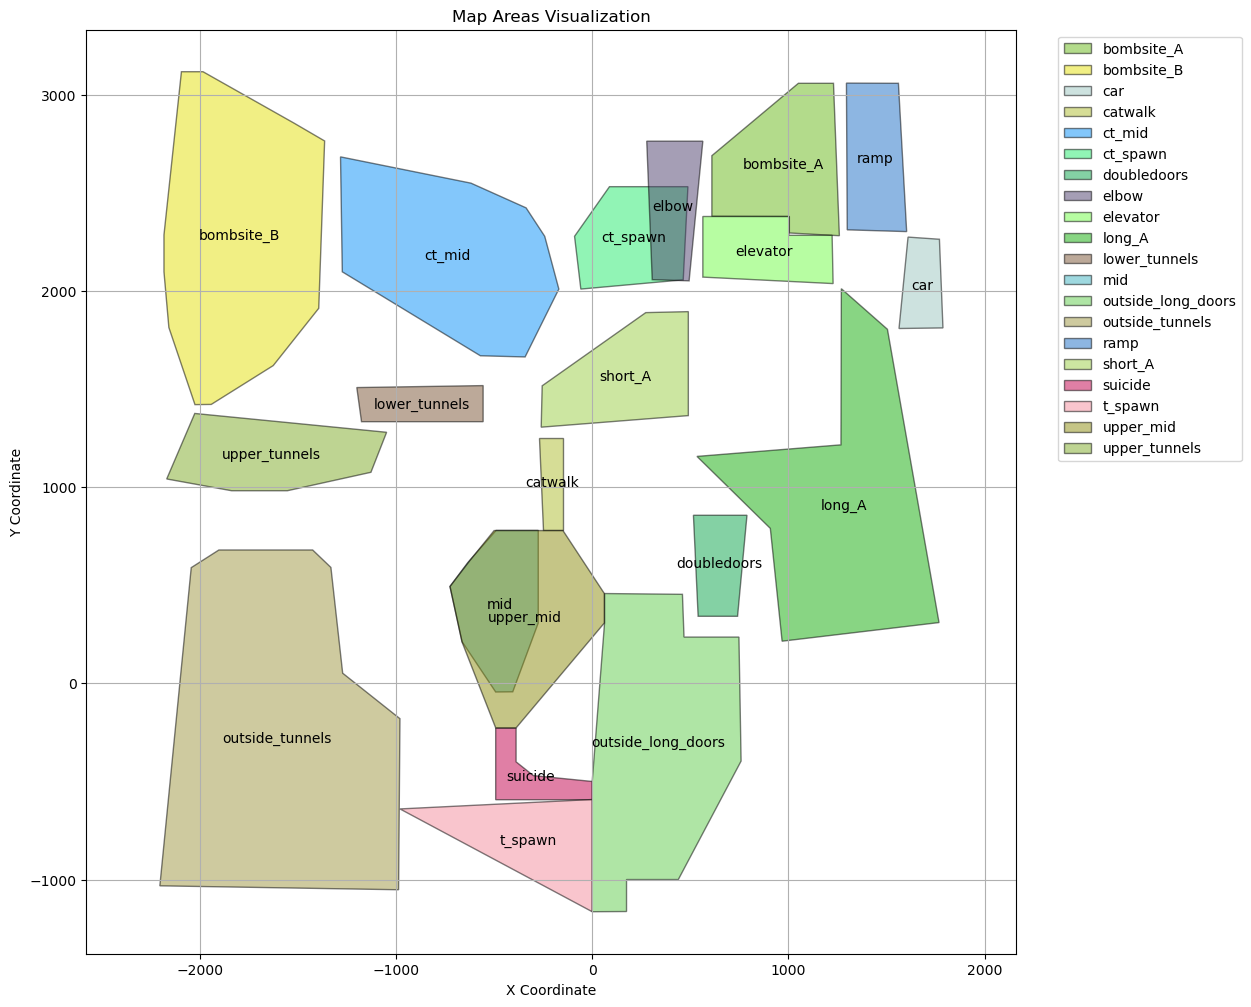

In [25]:
areas = load_map_data('map_bounds(in).csv')
dust2_areas = areas.get("dust2", {})

plot_areas(dust2_areas)